<a href="https://colab.research.google.com/github/EgorSu/house_price/blob/main/house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from catboost import cv, Pool
from statsmodels.stats import weightstats

Выводим информацию о датасете. 

In [2]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data['Id'].nunique()

1460

In [5]:
drop_list = ['Id'] 
features_nan = list(data.columns[data.isna().any()])
for feature in features_nan:
    p = data[feature].count()/data.shape[0]
    if p < 0.1:
        drop_list.append(feature)
    print(feature,  np.round(100 *(1 - p), 1), '% missing, type',data[feature].dtype)
          

LotFrontage 17.7 % missing, type float64
Alley 93.8 % missing, type object
MasVnrType 0.5 % missing, type object
MasVnrArea 0.5 % missing, type float64
BsmtQual 2.5 % missing, type object
BsmtCond 2.5 % missing, type object
BsmtExposure 2.6 % missing, type object
BsmtFinType1 2.5 % missing, type object
BsmtFinType2 2.6 % missing, type object
Electrical 0.1 % missing, type object
FireplaceQu 47.3 % missing, type object
GarageType 5.5 % missing, type object
GarageYrBlt 5.5 % missing, type float64
GarageFinish 5.5 % missing, type object
GarageQual 5.5 % missing, type object
GarageCond 5.5 % missing, type object
PoolQC 99.5 % missing, type object
Fence 80.8 % missing, type object
MiscFeature 96.3 % missing, type object


In [6]:
drop_list

['Id', 'Alley', 'PoolQC', 'MiscFeature']

In [7]:
feature_data = np.round(1 - data[features_nan].count()/data.shape[0], 3)
feature_for_zt = feature_data[(feature_data <= 0.9) & (feature_data >= 0.1)].index
feature_for_zt = list(data[feature_for_zt].select_dtypes(include = ["object"]).columns)
feature_for_zt

['FireplaceQu', 'Fence']

In [8]:
data_nan = pd.DataFrame()
for feature in feature_for_zt:
    data_nan[feature] = np.where(data[feature].isna(), 1, 0)
data_nan['val'] = data['SalePrice']    

In [9]:
data_nan.head()

,FireplaceQu,Fence,val
0,1,1,208500
1,0,1,181500
2,0,1,223500
3,0,1,140000
4,0,1,250000


In [10]:
def z_stat(x, y):
    D_x = x.var()/ x.count()
    D_y = y.var()/ y.count()
    print('z_stat: {}'.format((x.mean() - y.mean()) / np.sqrt(D_x + D_y)))

z_stat: 21.105376324953664


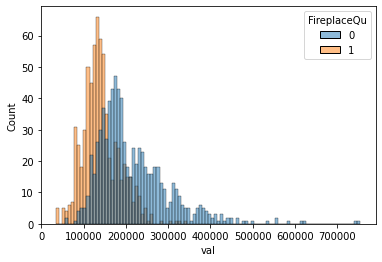

z_stat: -7.877748481880988


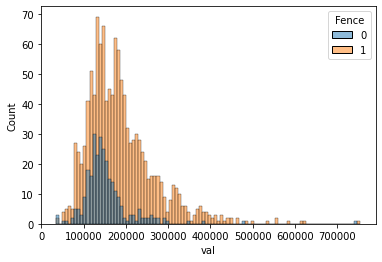

In [11]:
for i in feature_for_zt:
    g = data_nan.groupby(i)['val']
    sns.histplot(data = data_nan, x = 'val', hue = i, bins = 100)
    z_stat(g.get_group(0), g.get_group(1))
    plt.show()

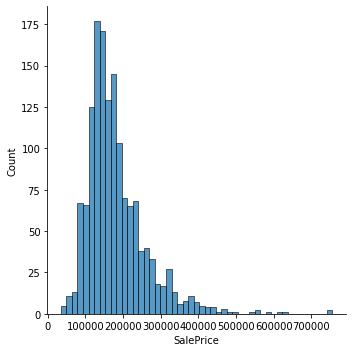

In [12]:
sns.displot(data, x = 'SalePrice')

In [13]:
def transform_func(x):
    return np.log1p(x)
    
def inverse_transform_func(x):
    return np.exp(x) - 1

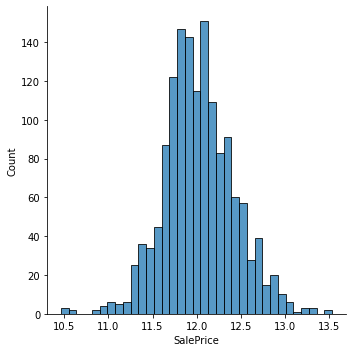

In [14]:
sns.displot(transform_func(data['SalePrice']))

In [15]:
categorial_features = list(data.select_dtypes(include = ["object"]).columns)
number_features = list(data.select_dtypes(include = ["number"]).columns )

Выведем количество уникальных значений для каждого числового признака.

In [16]:
data[number_features].nunique().sort_values()

BsmtHalfBath        3
HalfBath            3
FullBath            4
BsmtFullBath        4
Fireplaces          4
KitchenAbvGr        4
GarageCars          5
YrSold              5
BedroomAbvGr        8
PoolArea            8
OverallCond         9
OverallQual        10
TotRmsAbvGrd       12
MoSold             12
MSSubClass         15
3SsnPorch          20
MiscVal            21
LowQualFinSF       24
YearRemodAdd       61
ScreenPorch        76
GarageYrBlt        97
LotFrontage       110
YearBuilt         112
EnclosedPorch     120
BsmtFinSF2        144
OpenPorchSF       202
WoodDeckSF        274
MasVnrArea        327
2ndFlrSF          417
GarageArea        441
BsmtFinSF1        637
SalePrice         663
TotalBsmtSF       721
1stFlrSF          753
BsmtUnfSF         780
GrLivArea         861
LotArea          1073
Id               1460
dtype: int64

Некторые числовые признаки имет очень ограниченное кол-во уникальных значений. В файле house_price_picture.ipynb приведены точечные диаграммы, на которых видно, что при более 61 уникальном значении признак перестаёт быть дискретным. Исключение составляют признаки YearBuilt и GarageYrBlt, которые при большем кол-ве уникальных значений остаются дискретными. Выделим список дискретных численных признаков.  

In [17]:
n = 61
not_feature = ['Id', 'SalePrice']
categorial_features = list(data.select_dtypes(include = ["object"]).columns)
number_features = list(data.loc[:,data.nunique() > n ].select_dtypes(include = ["number"]).columns )
number_features_discrete = list(data.loc[:,data.nunique() <= n].select_dtypes(include = ["number"]).columns)

for i in ['YearBuilt', 'GarageYrBlt'] + not_feature + drop_list:
    if i in number_features:
        number_features.remove(i)
for i in not_feature + drop_list: 
    if i in number_features_discrete:
        number_features_discrete.remove(i)
for i in drop_list: 
    if i in categorial_features:
        categorial_features.remove(i)        
number_features_discrete.extend(['YearBuilt','GarageYrBlt'])

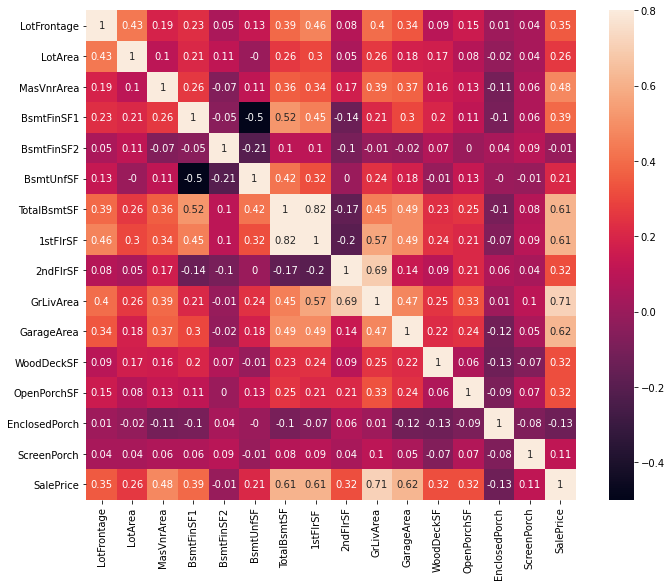

In [18]:
corrmat = np.round(data[number_features + ['SalePrice']].corr(),2)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, annot=True, square=True);

In [19]:
drop_list.append('BsmtFinSF2')
number_features.remove('BsmtFinSF2')

Посмотрим количество различных значений признаков. В house_price_picture показано соотношение различных значений для каждого категориального признака. Видно, что для многих признаков кол-во различных значений очень сильно несбалансированно. Обработаем эти признаки. Выделим значения которые составляют более 1%, остальные объеденим в одну категорию. В house_price_picture приведены точечные диаграммы непрерывных чисолвых признаков. На них видно, что существует. Пропущенные зачения категориальны признаков будем выделять в отдельную категорию. Пропущенные значения численных призаков будем заменять медианным значением признаков.

In [20]:
def get_labels(data, features, labels = None): 
    new_data = data.copy()
    if labels is None: 
        labels = {}
        for feature in features: 
            labels[feature] = np.round(new_data.groupby(feature)['SalePrice'].median().sort_values(), 0).to_dict()
            if 'none' not in labels[feature]:
                labels[feature]['none'] = np.round(new_data['SalePrice'].median(), 0)
    for feature in features:
        new_data[feature] = new_data[feature].map(labels[feature])
    return new_data, labels   

def remake_cat_feature(data, features, cat_feature_dict = None, fill_nan = 'missing'):
    new_data = data.copy()
    new_data.loc[:,features] = new_data.loc[:,features].fillna(fill_nan)
    if cat_feature_dict is None:
        cat_feature_dict = {
            feature:[i for i in new_data[feature].unique() if new_data.loc[new_data[feature] == i, feature].count()/data.shape[0] > 0.01] 
            for feature in features}
    for feature in features:
        new_data[feature] = new_data[feature].transform(lambda x: x if x in cat_feature_dict[feature] else 'none')  
    return new_data, cat_feature_dict

def fll_nan_value(data, features, nan_value = None):
    if nan_value is None: 
        nan_value = dict(data[features].median())
    data.loc[:,features] = data.loc[:,features].fillna(nan_value)        
    return nan_value                   

In [21]:
drop_list

['Id', 'Alley', 'PoolQC', 'MiscFeature', 'BsmtFinSF2']

In [24]:
def data_trasnform(data: pd.DataFrame, drop_features: list, cat_features: list,  numb_features_dis: list, numb_features: list, scaler = StandardScaler()):
    X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns = drop_features), data['SalePrice'], random_state = 10)
    
    X_train, train_cat_dict  = remake_cat_feature(X_train, cat_features)
    X_train, label_cat_dict = get_labels(X_train, cat_features)
    X_test, _ = remake_cat_feature(X_test, cat_features, train_cat_dict)
    X_test, _ = get_labels(X_test, cat_features, label_cat_dict)

    X_train, train_num_dict = remake_cat_feature(X_train, numb_features_dis)
    X_train, label_num_dict = get_labels(X_train, numb_features_dis)
    X_test, _ = remake_cat_feature(X_test, numb_features_dis, train_num_dict)
    X_test, _ = get_labels(X_test, numb_features_dis, label_num_dict)

    nan_dict = fll_nan_value(X_train, numb_features)
    _ = fll_nan_value(X_test, numb_features, nan_dict)

    X_train.drop(columns = 'SalePrice', inplace = True)
    X_test.drop(columns = 'SalePrice', inplace = True)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    col = list(cat_features + numb_features_dis + numb_features)
    Y_train = transform_func(Y_train)
    Y_test = transform_func(Y_test)
    return X_train, X_test, Y_train, Y_test, col


In [25]:
x_train, x_test, y_train, y_test, col = data_trasnform(data, drop_list, categorial_features, number_features_discrete, number_features)

In [26]:
def estimate_model(model, x_1, y_1, x_2, y_2, weight_func, columns = None):
    print('train score {0}, test score {1}'.format(model.score(x_1, y_1), model.score(x_2, y_2)))
    print('train RMSE {0}, test RMSE {1}'.format(mse(y_1, model.predict(x_1), squared = False), mse(y_2, model.predict(x_2), squared = False)))
    test_pred = model.predict(x_2)
    train_pred = model.predict(x_1)
    print('mean train error ', np.round(np.mean(train_pred - y_1), 7))
    print('mean test error ', np.round(np.mean(test_pred - y_2), 7))
    
    color_palette = sns.color_palette("pastel")
    sns.histplot( x = train_pred - y_1, label = "Training data", color = color_palette[0], fill = True)
    sns.histplot(x = test_pred - y_2, label = "Test data", color = color_palette[1], fill = True)
    plt.title("Errors")
    plt.xlabel("error")
    plt.ylabel("count")
    plt.legend(loc = "upper right")
    plt.show()
    
    plt.figure(figsize=(15,5))
    imp_coefs = pd.Series(data = weight_func, index = columns).sort_values() 
    imp_coefs.plot.bar()
    plt.title("feature importans")
    plt.show()


При кодировании категориальных признаков мы заменяли категории медианным значением целевой переменной, а целевая переменная имеет некоторую линейную зависимость от непрерывных числовых признаков(что видно из матрицы корреляции и графиков в файле house_price_picture). Тогда попробуем обучить линейные модели.

In [27]:
ridge = RidgeCV(alphas = np.geomspace(0.001, 1000.0, 100), cv = 5, scoring = 'neg_root_mean_squared_error')
ridge.fit(x_train, y_train)
#estimate_model(ridge, x_train_transform, y_train_transform, x_test_transform, y_test_transform)

RidgeCV(alphas=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87381742e-0...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
        cv=5, scoring='neg_root_mean_squared_error')

In [28]:
ridge.alpha_

284.8035868435805

train score 0.8793588006702031, test score 0.8822526045338562
train RMSE 0.13636768982433464, test RMSE 0.14356614992669461
mean train error  0.0
mean test error  -0.0008569


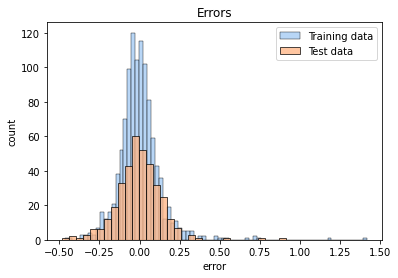

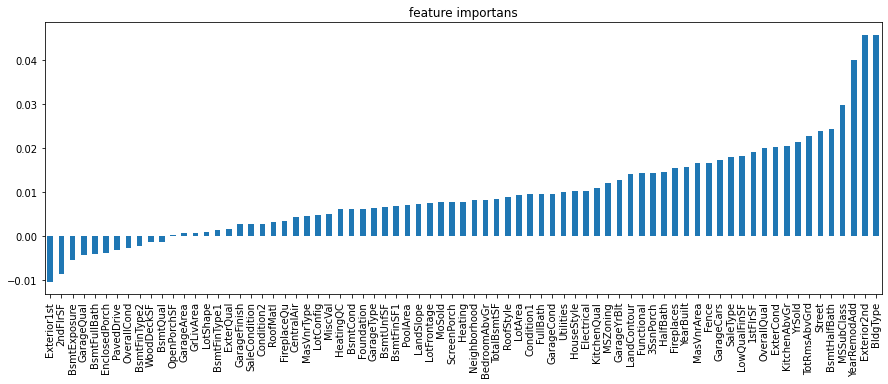

In [29]:
estimate_model(ridge, x_train, y_train, x_test, y_test, ridge.coef_, col)

In [30]:
elastic = ElasticNetCV(alphas = np.geomspace(0.00001, 10.0, 1000), cv = 5)
elastic.fit(x_train, y_train)

ElasticNetCV(alphas=array([1.00000000e-05, 1.01392541e-05, 1.02804473e-05, 1.04236067e-05,
       1.05687597e-05, 1.07159340e-05, 1.08651577e-05, 1.10164595e-05,
       1.11698682e-05, 1.13254132e-05, 1.14831241e-05, 1.16430313e-05,
       1.18051653e-05, 1.19695570e-05, 1.21362380e-05, 1.23052400e-05,
       1.24765955e-05, 1.26503372e-05, 1.28264983e-05, 1.30051125e-05,
       1.31862140e-05, 1.336983...
       7.27548353e+00, 7.37679760e+00, 7.47952252e+00, 7.58367791e+00,
       7.68928372e+00, 7.79636013e+00, 7.90492762e+00, 8.01500696e+00,
       8.12661920e+00, 8.23978568e+00, 8.35452806e+00, 8.47086827e+00,
       8.58882856e+00, 8.70843150e+00, 8.82969996e+00, 8.95265713e+00,
       9.07732653e+00, 9.20373200e+00, 9.33189772e+00, 9.46184819e+00,
       9.59360829e+00, 9.72720319e+00, 9.86265846e+00, 1.00000000e+01]),
             cv=5)

In [31]:
elastic.alpha_, elastic.l1_ratio_

(0.012563166024741201, 0.5)

train score 0.877689436562607, test score 0.8828491743858509
train RMSE 0.13730793750312595, test RMSE 0.14320199751558915
mean train error  0.0
mean test error  0.0006866


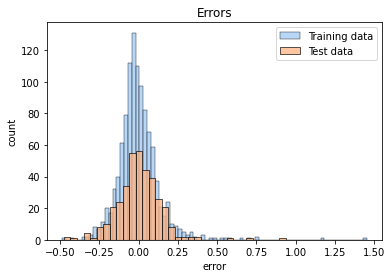

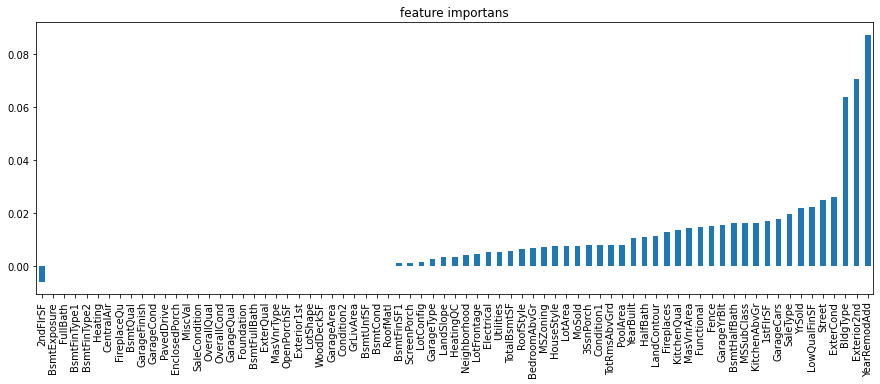

In [32]:
estimate_model(elastic, x_train, y_train, x_test, y_test, elastic.coef_, col)